In [1]:
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
from numpy import r_, exp, cos, sin, pi, zeros, ones, hanning, sqrt, log, floor, reshape, mean
from scipy import signal
from numpy.fft import fft

import pandas as pd
import torch
from torch import nn, optim, cuda
from torch.autograd import Variable

%matplotlib inline



D:\Python\Anaconda3\envs\PyTorch\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
D:\Python\Anaconda3\envs\PyTorch\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'H(f) [dB]')

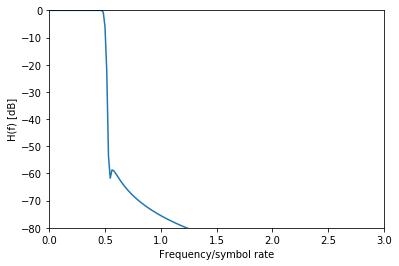

In [823]:
f0=1e+9  # RF freq.
fs = 30e+9  # sampling rate: this is not ADC sampling rate
baud = f0/4  # symbol rate
Ns = int(fs/baud)  # samples per symbol

#h_s = signal.firwin(Ns*8,1/Ns)
h_s = signal.firwin(Ns*64,1/Ns)
h_s_fft = np.fft.fft(h_s)
t = r_[0.0:len(h_s)]/(fs)
f = r_[0:len(h_s_fft)]/len(h_s_fft)*fs
plt.plot(f/baud,10*np.log10(np.square(h_s_fft)))
#plt.plot(t,h_s)
plt.xlim((0,3))
plt.ylim((-80,0))
plt.xlabel('Frequency/symbol rate')
plt.ylabel('H(f) [dB]')

967679
967679
Timestep = 33.333333333333336 ps


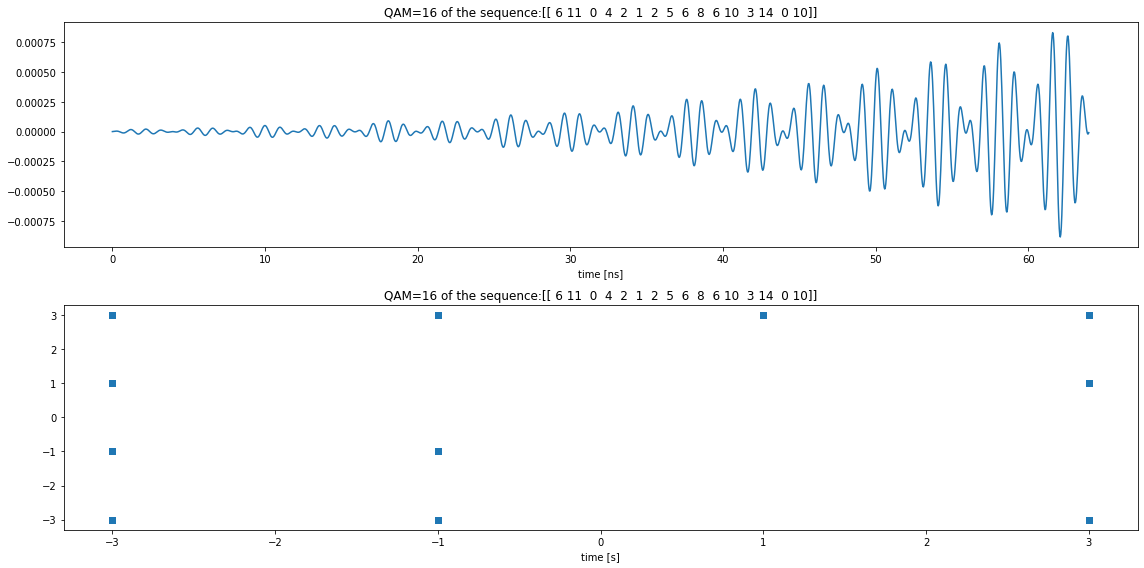

In [2]:
# 16 QAM RF signal Generation 
f0=1e+9  # RF Carrier freq.
fs = 30e+9  # sampling rate: this is not ADC sampling rate
baud = f0/4  # symbol rate
Ns = int(fs/baud)  # samples per symbol

#code = { 2: -3+3j, 6: -1+3j, 14: 1+3j, 10: 3+3j,
#        3: -3+1j, 7: -1+1j, 15: 1+1j, 11: 3+1j,
#        1: -3-1j, 5: -1-1j, 13: 1-1j, 9: 3-1j,
#        0: -3-3j, 4: -1-3j, 12: 1-3j, 8: 3-3j}
Nbits = 8000  # number of bits
N = Nbits * Ns
  
Ndisp = 16 ;   #number of bits to display

code = np.array((-3-3j, -3-1j,-3+3j,-3+1j,-1-3j,-1-1j,-1+3j,-1+1j,+3-3j,+3-1j,+3+3j,+3+1j,1-3j,+1-1j,1+3j,1+1j))
#code = np.array((-3-3j,-1-3j,-3-3j,-1-3j,-3-3j,-1-3j,-3-3j,-1-3j,-3-3j,-1-3j,-3-3j,-1-3j,-3-3j,-1-3j,-3-3j,-1-3j))

np.random.seed(seed=1)
bits = np.int16(np.random.rand(Nbits,1)*16) 

message = zeros(N, dtype='complex')
symbol = code[bits].ravel()
message[::Ns] = symbol

# Convolve
h = np.ones(Ns)
message = signal.fftconvolve(message,h,mode='full')

t = r_[0.0:len(message)]/(fs)
QAM = message*exp(1j*2*pi*f0*t)
#QAM = 3*exp(1j*2*pi*f0*t)
QAM_real = np.real(QAM)
QAM_imag= np.imag(QAM)

#Frequency response of QAM

QAM_f = (np.fft.fft(QAM_real))
f = r_[0:len(QAM_f)]/len(QAM_f)*fs


# Raised cosine pulse shaping
imp = zeros(N,dtype='complex')
imp[::Ns] = code[bits].ravel()

h_s = signal.firwin(Ns*64,1.0/Ns)
imp_sinc = signal.fftconvolve(imp,h_s,mode='full')
t = r_[0.0:len(imp_sinc)]/fs



#shaped QAM
QAM_s = imp_sinc*exp(1j*2*pi*f0*t)
#QAM_s = exp(1j*2*pi*f0*t)+exp(1j*2*pi*1.05*f0*t)
QAM_s_real = np.real(QAM_s)
#Frequency response of shaped QAM
QAM_sf = (np.fft.fft(QAM_s_real))


f = r_[0:len(imp_sinc)]/len(imp_sinc)*fs
print(len(imp_sinc))

print(len(QAM_s))

print('Timestep =', 1e12*1/fs,'ps')

fig = plt.figure(figsize = (16,8))
plt.subplot(211)
#plt.plot(t[:Ns*Ndisp]*1e+9,QAM_real[:Ns*Ndisp])
plt.plot(t[:Ns*Ndisp]*1e+9,(QAM_s_real[:Ns*Ndisp]))
#plt.plot(t[:Ns*Ndisp],np.imag(message[:Ns*Ndisp]))
plt.xlabel('time [ns]')
plt.title("QAM=16 of the sequence:"+ np.array2string(np.transpose(bits[:Ndisp])))

plt.subplot(2,1,2)
#plt.plot(t[:Ns*Ndisp],QAM_imag[:Ns*Ndisp])
plt.plot(np.real(message[:Ns*Ndisp]),np.imag(message[:Ns*Ndisp]),'s')
#plt.plot(np.real(code),np.imag(code), 's')
#plt.plot(t[:Ns*Ndisp],np.imag(message[:Ns*Ndisp]))
plt.xlabel('time [s]')
plt.title("QAM=16 of the sequence:"+ np.array2string(np.transpose(bits[:Ndisp])))
plt.tight_layout()

In [3]:
def Tshift(arr,tau):
    num = int(tau*fs)
    arr=np.roll(arr,num)
    if num<0:
         np.put(arr,range(len(arr)+num,len(arr)),0)
    elif num > 0:
         np.put(arr,range(num),0)
    return arr



# Channel Model 

def H_ch_Tshift(A, tau, IN):          #Take Complex value input and give complex out
    
    H_ch_OUT= zeros(len(IN),dtype='complex')
  
    for i in range(len(A)):
        H_ch_OUT += A[i]*Tshift(IN,tau[i])
       

    return H_ch_OUT


# Band-pass Filtering at f0 with 3dB cut-off freq of fl, fh
def BPF(order, fl, fh, fs):
    nyq = 0.5*fs
    low=fl/nyq
    high=fh/nyq
    b,a = signal.butter(order, [low, high], btype='band')
    return b,a


# Phase shifter introducing phase (deg) of 'j*phase', IN: complex input, complex out.
def PS_OUT(phase, IN):
    OUT = IN*exp(1j*phase*np.pi/180)        
    return OUT



# CX tab
def Tab_Tshift(tau, W_I, W_Q, phase, IN):     #Just gives frequency impulse response of one Tab with same dimension as IN
    H_Tab_OUT= zeros(len(IN),dtype='complex')
    for i in range(len(tau)):
        H_Tab_OUT += (W_I[i]+exp(1j*phase*np.pi/180)*W_Q[i])*Tshift(IN, tau[i])
        #H_Tab_OUT += Tshift(IN, tau[i])
    return H_Tab_OUT

# DSP
def r(u,k,N):
    Sum = 0

    for n in range(N):
        q=0
        if n+k > N-1:
            q = n+k-N
        elif n+k < 0:
            q = n+k+N
        else:
            q = n+k
        Sum += u[q]*np.conjugate(u[n])
    return Sum/N

def p(u,d,k,N):
    Sum = 0
    for n in range(N):
        q=0
        if n+k<0:
            q = n+k+N
        else:
            q = n+k
        Sum += u[q]*np.conjugate(d[n])
    return Sum/N

(21, 967679)
(21, 967679)


Text(0.5, 0, 'time [ns]')

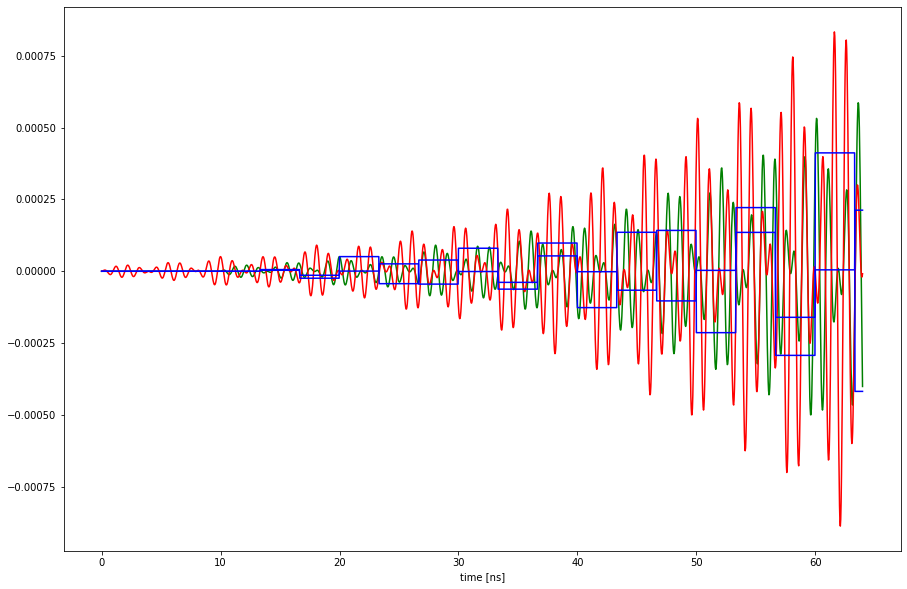

In [51]:
# ******************Testbench for wireless channel *************


b,a = BPF(4,0.85e9,1.15e+9, fs)
w, h = signal.freqs(b, a)
TXSig=signal.lfilter(b,a,QAM_s)  #no delay : filtfilt, yesdelay: lfilter

TXSig_fft = (np.fft.fft(np.real(TXSig)))

#Channel response 

A_ch=[0.1,0.05, 0.0025, 0.00125]
tau_ch = [10e-9, 20e-9, 30e-9, 40e-9]

RXSig = H_ch_Tshift(A_ch, tau_ch, TXSig)
RXSig_fft=np.fft.fft(np.real(RXSig[:len(TXSig)]))


# Testbench for multiple cancellor branches
Num_tab = 21
tau_unit=2e-9
Array = np.linspace(0,Num_tab-1,Num_tab)
tau=np.dot(tau_unit,Array)




# Downconversion


QAM_s_DN = QAM_s*exp(-1j*2*pi*f0*t)

RXSig_DN = RXSig*exp(-1j*2*pi*f0*t)
f_ADC = 300e+6
factor_ADC = int(fs/f_ADC)
# Quantization
QAM_s_DN_dt= np.repeat(QAM_s_DN[::factor_ADC],factor_ADC)
len_dt = len(QAM_s_DN_dt)
QAM_s_DN_dt = QAM_s_DN_dt[:len(QAM_s_DN)]

RXSig_DN_dt= np.repeat(RXSig_DN[::factor_ADC],factor_ADC)
RXSig_DN_dt = RXSig_DN_dt[:len(RXSig_DN)]


# Delay tapped signal 
DLSig = np.zeros((len(tau),len(QAM_s)),dtype='complex')
DLSig_DN = np.zeros((len(tau),len(QAM_s)),dtype='complex')
DLSig_DN_dt = np.zeros((len(tau),len_dt),dtype='complex')



for i in range(Num_tab):
    DLSig[i,:] = Tshift(QAM_s,i*tau_unit)
    DLSig_DN[i,:] = DLSig[i,:]*exp(-1j*2*pi*f0*t)
    DLSig_DN_dt[i,:] = np.repeat(DLSig_DN[i,::factor_ADC],factor_ADC)

DLSig_DN_dt = np.delete(DLSig_DN_dt,np.s_[len(QAM_s):len_dt],1)
print(DLSig_DN_dt.shape)

print(DLSig_DN.shape)

fig = plt.figure(figsize = (15,10))
plt.plot(1e+9*t[:Ns*Ndisp],DLSig[5,:Ns*Ndisp],'g')
plt.plot(1e+9*t[:Ns*Ndisp],QAM_s_real[:Ns*Ndisp],'r')
plt.plot(1e+9*t[:Ns*Ndisp],DLSig_DN_dt[5,:Ns*Ndisp],'b')
plt.plot(1e+9*t[:Ns*Ndisp],DLSig_DN_dt[6,:Ns*Ndisp],'b')
plt.xlabel('time [ns]')


[1.52709486e-03-2.05131383e-20j 1.42578450e-03+5.49872413e-21j
 1.39473666e-03+7.46082239e-21j 1.35636160e-03-4.89098957e-20j
 1.28779180e-03+1.29464777e-20j 1.22181459e-03+6.08104041e-20j
 1.19325270e-03+8.32462249e-20j 1.09398620e-03-5.55319160e-20j
 9.76888073e-04-4.81419006e-20j 8.25169706e-04-1.39125636e-20j
 5.01531105e-04-9.59141782e-21j 3.18381334e-04-5.03385784e-21j
 2.98950353e-04-7.96458187e-22j 2.52383456e-04+7.20163287e-21j
 5.19116451e-05-3.99536795e-20j 5.37398312e-05-3.16956930e-21j
 2.14802473e-04-6.57553747e-21j 1.55839903e-04+7.80208164e-21j
 1.14568387e-04-4.49851577e-21j 1.27522043e-04+1.56885476e-20j
 1.38062077e-04+2.88684805e-20j]
654.8381668382403


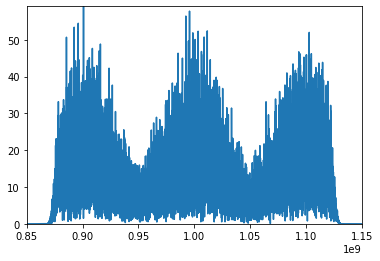

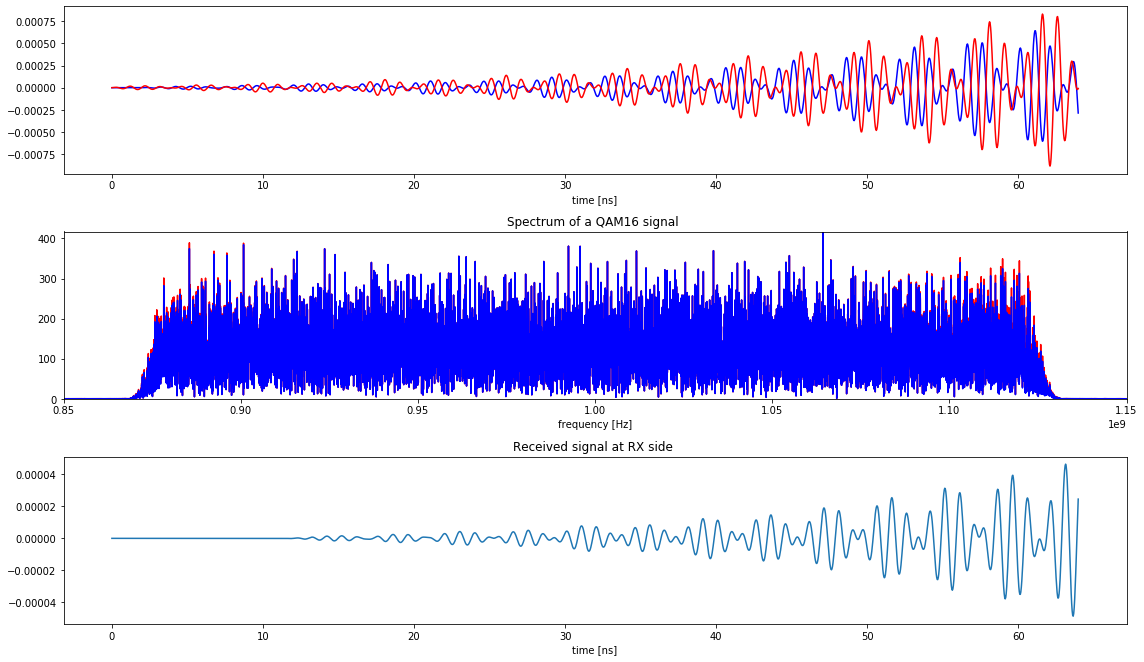

In [52]:
####### DSP part for weight initialization #####


factor_tau = int(tau_unit*fs)
M = len(tau)
R= np.zeros((M,M),dtype='complex')
P= np.zeros((M,1),dtype='complex')
u_DN = QAM_s_DN_dt[len(QAM_s)//8::factor_tau]
d_DN = RXSig_DN_dt[len(QAM_s)//8::factor_tau]
t_dt= t[len(QAM_s)//8::factor_tau]
W=np.zeros((M,1),dtype='complex')

for i in range(M):
    for j in range(M):
        R[i,j] = r(u_DN,j-i,(7*len(QAM_s)//(8*factor_tau)))
    P[i]=p(u_DN,d_DN,-i,(7*len(QAM_s)//(8*factor_tau)))
W = np.conjugate(np.linalg.inv(R)@P)

W_I = np.real(W)
W_Q = np.imag(W)

# Find Eigenvalues of R
eigenvalues = np.linalg.eigvals(R)
print(eigenvalues)
print(1/np.abs(np.max(eigenvalues)))

freq_RXSig = r_[0:len(RXSig_fft)]/len(RXSig_fft)*fs
plt.plot(freq_RXSig,np.abs(RXSig_fft))
plt.axis((0.85e+9,1.15e9,0,max(abs(RXSig_fft))))
'''
h_ch_env = h_ch(A, tau_ch, np.real(TXSig))
RXSig = signal.convolve(TXSig,h_ch_env,'full')
'''



fig = plt.figure(figsize = (16,12))
plt.subplot(411)
plt.plot(1e+9*r_[0.0:len(TXSig[:Ns*Ndisp])]/fs, np.real(TXSig[:Ns*Ndisp]), 'b')
plt.plot(1e+9*t[:Ns*Ndisp],QAM_s_real[:Ns*Ndisp],'r')
plt.xlabel('time [ns]')


freq_TXSig = r_[0:len(TXSig_fft)]/len(TXSig_fft)*fs
plt.subplot(412)
plt.plot(f,abs(QAM_sf[0:len(QAM_sf)]), 'r')
plt.plot(freq_TXSig,abs(TXSig_fft[0:len(TXSig_fft)]), 'b')
plt.xlabel('frequency [Hz]')
plt.title('Spectrum of a QAM16 signal ')
plt.axis((0.85e+9,1.15e9,0,max(abs(TXSig_fft))))




plt.subplot(413)
#plt.plot(r_[0.0:len(h_ch_env[:Ns*Ndisp])]/fs, np.real(h_ch_env[:Ns*Ndisp]))
#plt.plot(r_[0.0:len(RXSig[:Ns*Ndisp])]/fs, np.real(RXSig[:Ns*Ndisp]))
plt.plot(1e+9*r_[0.0:len(RXSig[:Ns*Ndisp])]/fs, RXSig[:Ns*Ndisp])

plt.xlabel('time [ns]')
plt.title('Received signal at RX side ')
#plt.plot(freq_TXSig,abs(H_ch_env[0:len(H_ch_env)//2]))




plt.tight_layout()



967679
967679


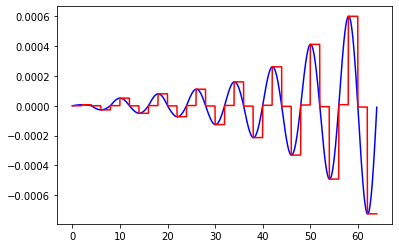

In [29]:
QAM_s_DN = QAM_s*exp(-1j*2*pi*f0*t)
RXSig_DN = RXSig*exp(-1j*2*pi*f0*t)
f_ADC = 500e6
factor_ADC = int(fs/f_ADC)
# Quantization
QAM_s_DN_dt= np.repeat(QAM_s_DN[::factor_ADC],factor_ADC)
QAM_s_DN_dt = QAM_s_DN_dt[:len(QAM_s_DN)]

#plt.plot(1e+9*t[:Ns*Ndisp],QAM_s[:Ns*Ndisp],'g')
plt.plot(1e+9*t[:Ns*Ndisp],QAM_s_DN[:Ns*Ndisp],'b')
plt.plot(1e+9*t[:Ns*Ndisp],QAM_s_DN_dt[:Ns*Ndisp],'r')
print(len(QAM_s_DN_dt))
print(len(QAM_s_DN))

(1.3333231533801979e-05-2.4883683031656397e-05j)
W_LMS= [[-0.00913336+1.55255367e-03j]
 [ 0.00275458-5.57534710e-04j]
 [ 0.00551861-2.52493715e-04j]
 [-0.01416718+2.17700165e-03j]
 [ 0.00368699-8.43424239e-04j]
 [ 0.01298102-3.78506718e-03j]
 [ 0.03069382-4.98518054e-03j]
 [ 0.06182022-8.61568865e-03j]
 [-0.00684456+3.78619900e-04j]
 [ 0.01163322-1.68826798e-03j]
 [-0.01596362+3.49421414e-03j]
 [ 0.02874442-3.33423825e-03j]
 [ 0.04004943-5.56122874e-03j]
 [-0.00962729+1.07143838e-03j]
 [ 0.0020073 +2.36843491e-04j]
 [ 0.00470705+1.13286615e-03j]
 [ 0.00355329+2.45375734e-04j]
 [ 0.00276272+8.87178878e-05j]
 [ 0.00238658+7.31238541e-04j]
 [ 0.00112226+6.31140498e-04j]
 [ 0.00515423-3.80689791e-04j]]
W_Wiener= [[-7.41438541e-03+0.00102453j]
 [ 3.55649869e-03-0.00110599j]
 [ 6.27584203e-03-0.00047317j]
 [-1.34542641e-02+0.00228365j]
 [ 3.98601237e-03-0.00081555j]
 [ 1.28666187e-02-0.0038355j ]
 [ 2.93025456e-02-0.00509852j]
 [ 6.04461918e-02-0.00899932j]
 [-8.20161686e-03-0.00027565j]
 [ 

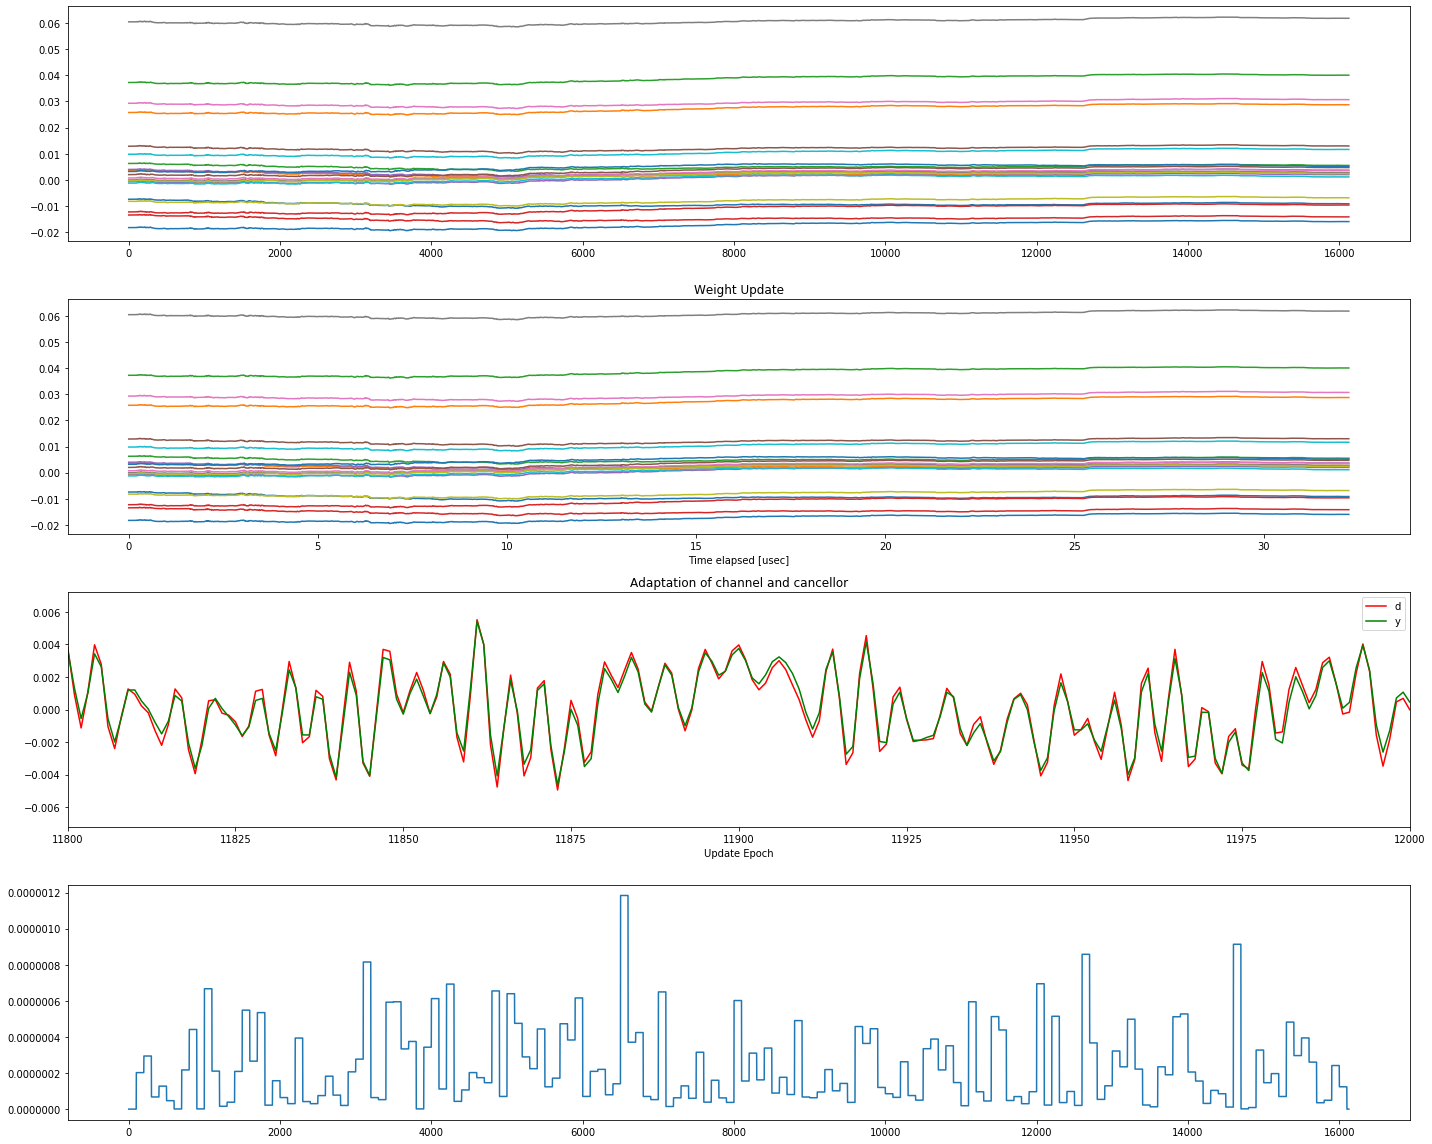

In [59]:
# LMS Algorithm

N_LMS = len(RXSig)//N_step
N_step = int(tau_unit*fs)
#N_step = 37

W_LMS = np.zeros((M,N_LMS),dtype='complex')

#Wiener initialization
W_LMS[:,0]=np.reshape(W,(len(tau)))

d = RXSig[:N_LMS*N_step:N_step] #- np.average(RXSig[:N_LMS*N_step:N_step])
print(np.average(RXSig[:N_LMS*N_step:N_step]))
y = np.zeros(N_LMS, dtype='complex')
mu = 1

e = np.zeros(N_LMS, dtype='complex')


#CXSig = Tab_Tshift(tau, W_I, W_Q, 90, QAM_s)
#ESig = RXSig-CXSig



e[0] = d[0]-y[0]
#W_LMS[0,1] = W_LMS[0,0] + 2*mu*e[0]*np.conjugate(QAM_s[0])
#W_LMS[1:,1] = W_LMS[1:,0]

#print(W_LMS[:,2])

for i in range(N_LMS-1):
    if i%5 == 1:
        mu *= 0.9995
        
    
    for k in range(len(tau)):
        y[i] += W_LMS[k,i]*QAM_s[(i-k)*(N_step)]
    e[i] = d[i] - y[i]
    e[i]=e[i-i%factor_ADC]
    e_DN_dt=e[i]*exp(-1j*2*pi*f0*t[(i)*(N_step)])
    for j in range(len(tau)):
        if i-j<0:
            W_LMS[j,i+1] = W_LMS[j,i]
        else:
            W_LMS[j,i+1] = W_LMS[j,i] + 2*mu*e_DN_dt*np.conjugate(QAM_s_DN_dt[(i-j)*(N_step)])


        
W_LMS_final = np.reshape(W_LMS[:,N_LMS-1],(M,-1))        
print('W_LMS=',W_LMS_final)
print('W_Wiener=',W)
n = np.arange(N_LMS)

fig = plt.figure(figsize = (20,16))
plt.subplot(411) 
for i in range(len(tau)):
    plt.plot(n,np.real(W_LMS[i,:]), label="real of W_0"+str(i))

#plt.legend()
plt.subplot(412)
for i in range(len(tau)):
    plt.plot(1e+6*n*tau_unit,np.real(W_LMS[i,:]), label="real of W_0"+str(i))
    
plt.title("Weight Update")
plt.xlabel('Time elapsed [usec]')


plt.subplot(413)
plt.plot(n,d, 'r', label ='d')
plt.plot(n,y, 'g', label ='y')
plt.xlabel('Update Epoch')
plt.title('Adaptation of channel and cancellor')
plt.legend()
plt.axis((11800,12000,-max(abs(y)),max(abs(y))))
#plt.xlim(3800,4000)
#plt.semilogy(n,np.square(np.abs(e)))

plt.subplot(414)
plt.plot(n,np.square(np.abs(e)))
print(np.average(np.square(np.abs(e[-1000:-10]))))


plt.tight_layout()


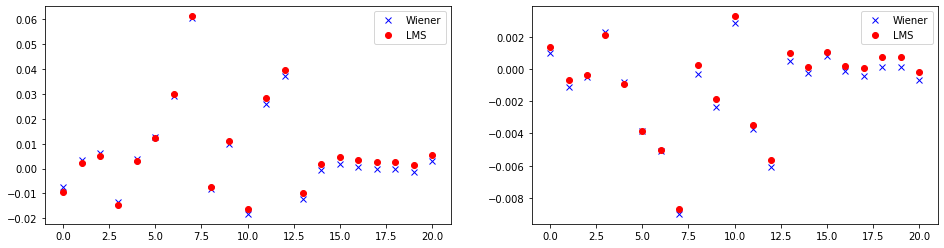

In [55]:

fig = plt.figure(figsize = (16,4))
plt.subplot(121) 
plt.plot(np.real(W),'bx',label='Wiener')
plt.plot(np.real(W_LMS_final),'ro', label = 'LMS')
plt.legend()

plt.subplot(122)
plt.plot(np.imag(W),'bx',label ='Wiener')
plt.plot(np.imag(W_LMS_final),'ro', label = 'LMS')
plt.legend()


D:\Python\Anaconda3\envs\PyTorch\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
D:\Python\Anaconda3\envs\PyTorch\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
D:\Python\Anaconda3\envs\PyTorch\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


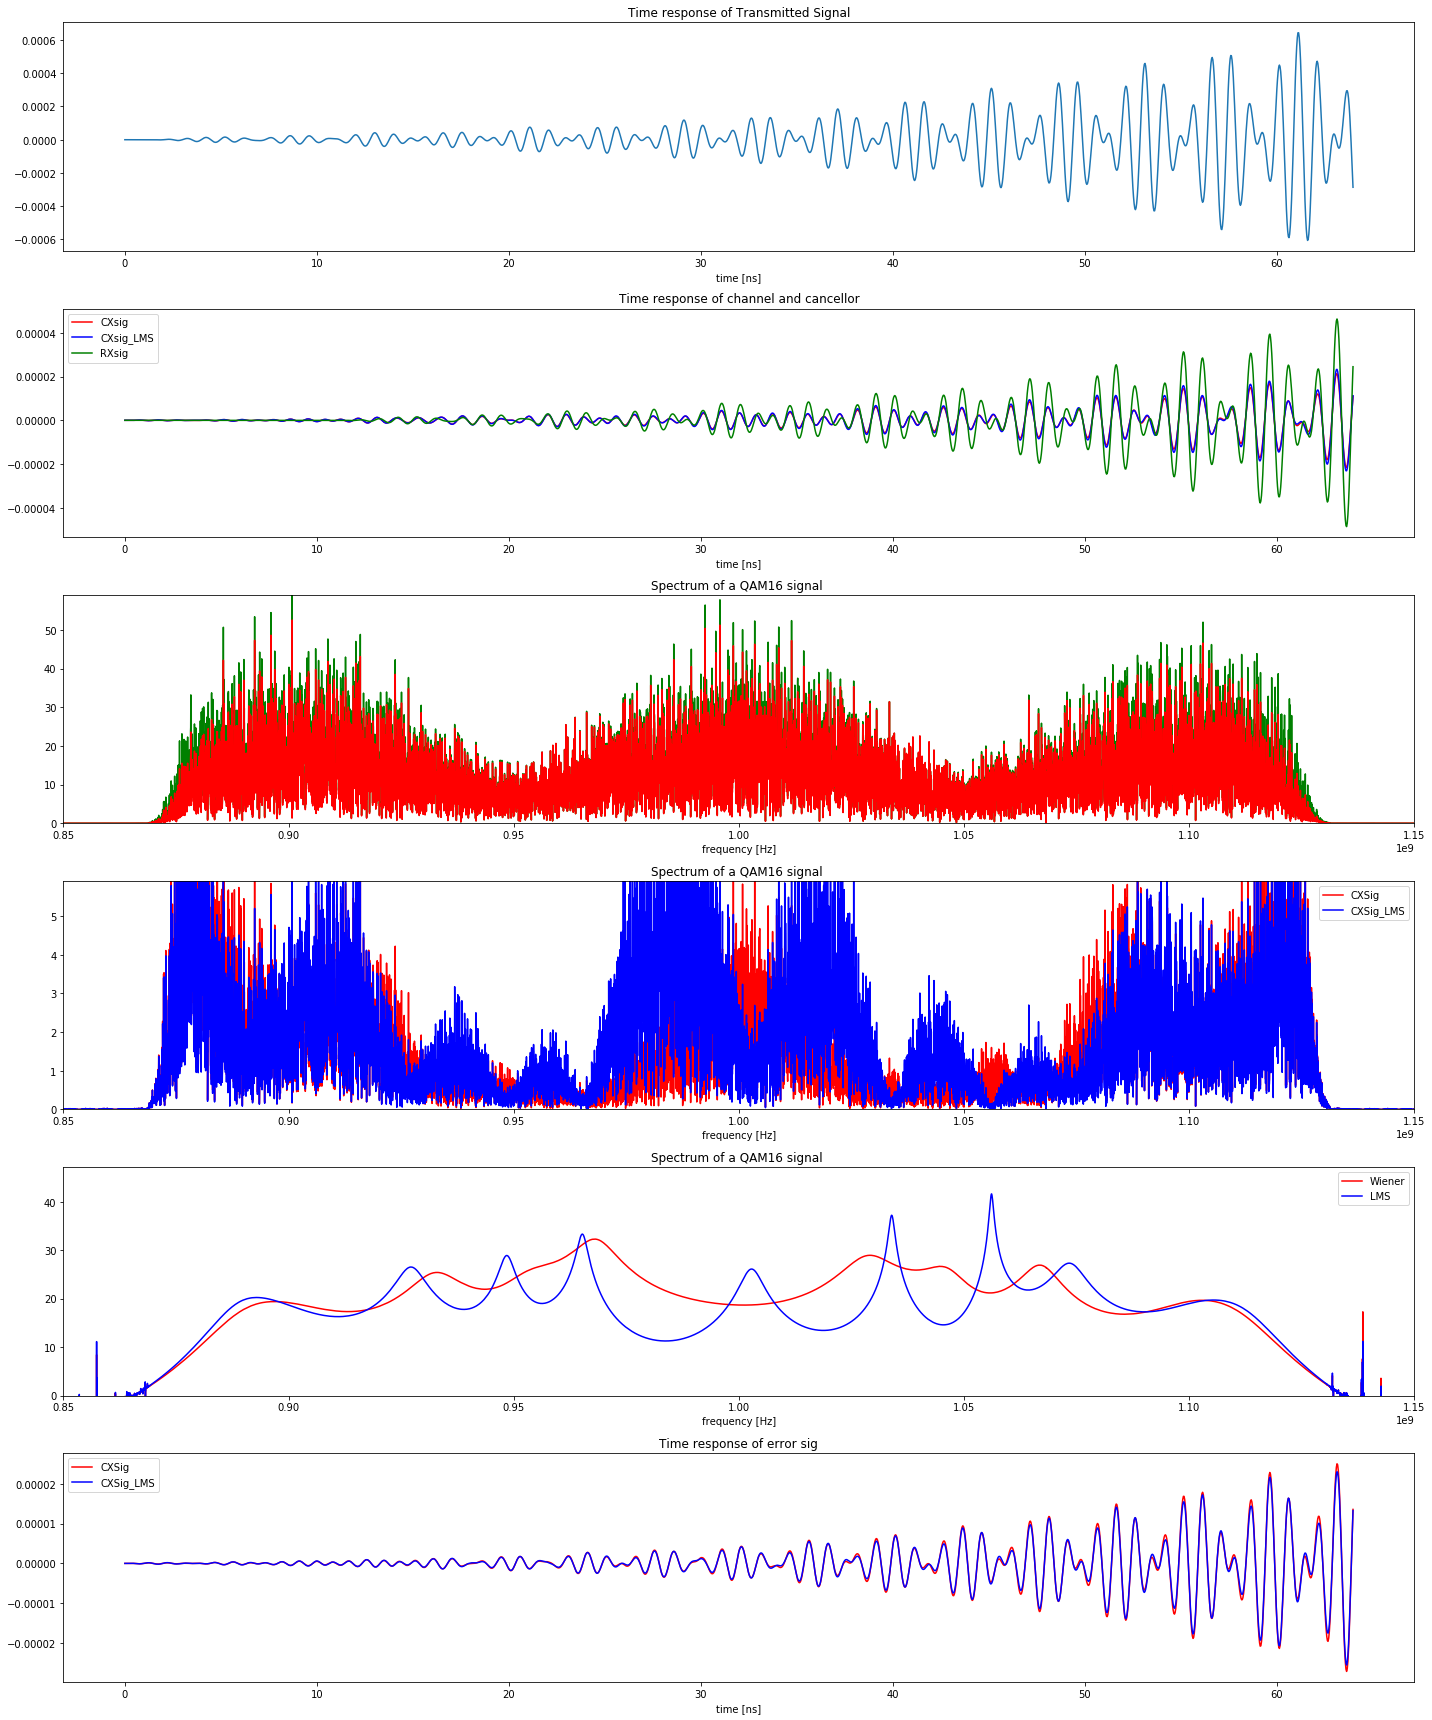

In [56]:
#### Cancellation in effect ####


#Cancellor output signal
CXSig = Tab_Tshift(tau, W_I, W_Q, 90, QAM_s)
CXSig_fft=np.fft.fft(np.real(CXSig))

CXSig_LMS = Tab_Tshift(tau, np.real(W_LMS_final), np.imag(W_LMS_final), 90, QAM_s)
CXSig_LMS_fft=np.fft.fft(np.real(CXSig_LMS))

#Error signal 
ESig=RXSig-CXSig
ESig_fft=np.fft.fft(np.real(ESig))

ESig_LMS=RXSig-CXSig_LMS
ESig_LMS_fft=np.fft.fft(np.real(ESig_LMS))

Suppression = 20*np.log10(np.divide(abs(RXSig_fft),abs(ESig_fft)))
Suppression_LMS = 20*np.log10(np.divide(abs(RXSig_fft),abs(ESig_LMS_fft)))


fig = plt.figure(figsize = (20,24))
plt.subplot(611) 
plt.plot(1e+9*r_[0.0:len(TXSig[:Ns*Ndisp])]/fs, np.real(TXSig[:Ns*Ndisp]))
plt.xlabel('time [ns]')
plt.title('Time response of Transmitted Signal')

plt.subplot(612)
plt.plot(1e+9*r_[0.0:len(CXSig[:Ns*Ndisp])]/fs, np.real(CXSig[:Ns*Ndisp]), 'r', label='CXsig')
plt.plot(1e+9*r_[0.0:len(CXSig_LMS[:Ns*Ndisp])]/fs, np.real(CXSig_LMS[:Ns*Ndisp]), 'b', label='CXsig_LMS')
plt.plot(1e+9*r_[0.0:len(RXSig[:Ns*Ndisp])]/fs, np.real(RXSig[:Ns*Ndisp]), 'g', label='RXsig')
#plt.plot(r_[0.0:len(RXSig[:Ns*Ndisp])]/fs, np.real(RXSig[:Ns*Ndisp]), 'g')

plt.xlabel('time [ns]')
plt.title('Time response of channel and cancellor')
plt.legend()

plt.subplot(613)

plt.plot(r_[0:len(RXSig_fft)]/len(RXSig_fft)*fs, abs(RXSig_fft[0:len(RXSig_fft)]), 'g')
plt.plot(r_[0:len(CXSig_fft)]/len(CXSig_fft)*fs, abs(CXSig_fft[0:len(CXSig_fft)]), 'r')
plt.xlabel('frequency [Hz]')
plt.title('Spectrum of a QAM16 signal ')
plt.axis((0.85e9,1.15e9,0,max(abs(RXSig_fft))))

plt.subplot(614)
#np.pad(QAM_f, (2, 3), 'constant')

plt.plot(r_[0:len(ESig_fft)]/len(ESig_fft)*fs, abs(ESig_fft[0:len(ESig_fft)]), 'r', label = 'CXSig')
plt.plot(r_[0:len(ESig_LMS_fft)]/len(ESig_fft)*fs, abs(ESig_LMS_fft[0:len(ESig_fft)]), 'b', label = 'CXSig_LMS')
plt.xlabel('frequency [Hz]')
plt.title('Spectrum of a QAM16 signal ')
plt.axis((0.85e9,1.15e9,0,0.1*max(abs(RXSig_fft))))
plt.legend()

plt.subplot(615)
#np.pad(QAM_f, (2, 3), 'constant')

plt.plot(r_[0:len(ESig_fft)]/len(ESig_fft)*fs, Suppression, 'r', label = 'Wiener')
plt.plot(r_[0:len(ESig_fft)]/len(ESig_fft)*fs, Suppression_LMS, 'b', label = 'LMS')
#plt.plot(r_[0:len(ESig_LMS_fft)]/len(ESig_fft)*fs, abs(ESig_LMS_fft[0:len(ESig_fft)]), 'b', label = 'CXSig_LMS')
plt.xlabel('frequency [Hz]')
plt.title('Spectrum of a QAM16 signal ')
plt.axis((0.85e9,1.15e9,0,np.max([Suppression,Suppression_LMS])))
plt.legend()


plt.subplot(616)
plt.plot(1e+9*r_[0.0:len(ESig[:Ns*Ndisp])]/fs, np.real(ESig[:Ns*Ndisp]), 'r', label = 'CXSig')
plt.plot(1e+9*r_[0.0:len(ESig_LMS[:Ns*Ndisp])]/fs, np.real(ESig_LMS[:Ns*Ndisp]), 'b', label = 'CXSig_LMS')

#plt.plot(r_[0.0:len(RXSig[:Ns*Ndisp])]/fs, np.real(RXSig[:Ns*Ndisp]), 'g')

plt.xlabel('time [ns]')
plt.title('Time response of error sig')
plt.legend()



plt.tight_layout()




D:\Python\Anaconda3\envs\PyTorch\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


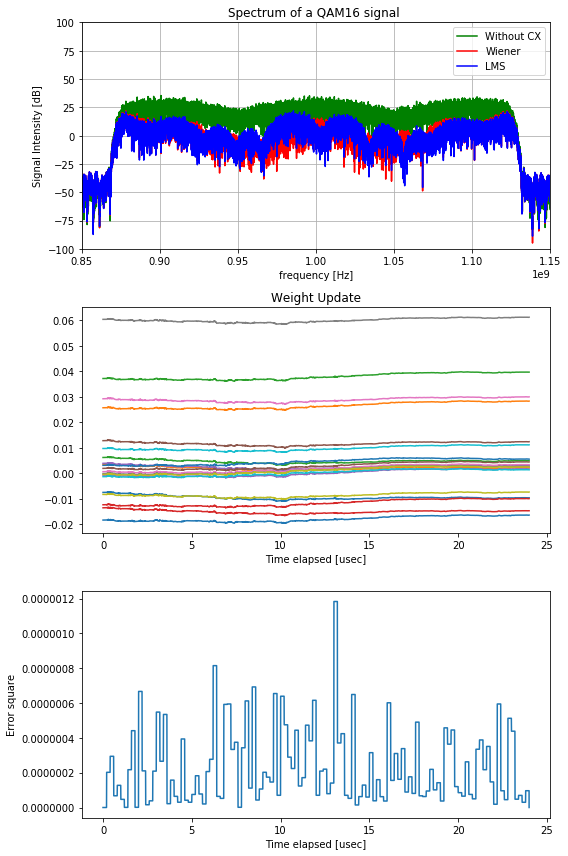

In [58]:
fig = plt.figure(figsize = (8,12))
plt.subplot(311)

plt.plot(r_[0:len(RXSig_fft)]/len(RXSig_fft)*fs, 20*np.log10(np.abs(RXSig_fft)), 'g', label = 'Without CX')

plt.plot(r_[0:len(ESig_fft)]/len(ESig_fft)*fs, 20*np.log10(np.abs(ESig_fft)), 'r', label = 'Wiener')
plt.plot(r_[0:len(ESig_fft)]/len(ESig_fft)*fs, 20*np.log10(np.abs(ESig_LMS_fft)), 'b', label = 'LMS')

plt.xlabel('frequency [Hz]')
plt.ylabel('Signal Intensity [dB]')
plt.title('Spectrum of a QAM16 signal ')
plt.legend()
plt.xlim(0.85e9,1.15e9)
plt.ylim(-100,100)
plt.grid()

plt.subplot(312)
for i in range(len(tau)):
    plt.plot(1e+6*n*tau_unit,np.real(W_LMS[i,:]), label="real of W_0"+str(i))
    
    

plt.xlabel('Time elapsed [usec]')
plt.title("Weight Update")

#plt.legend()

plt.subplot(313)
plt.plot(n*1e+6*tau_unit,np.square(np.abs(e)))
plt.ylabel('Error square')
plt.xlabel('Time elapsed [usec]')

#plt.ylim(0,1e-8)
plt.tight_layout()

In [965]:
print(len(TXSig))
print(len(QAM_s))
print(len(RXSig))
print(len(CXSig))

967679
967679
967679
967679


D:\Python\Anaconda3\envs\PyTorch\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


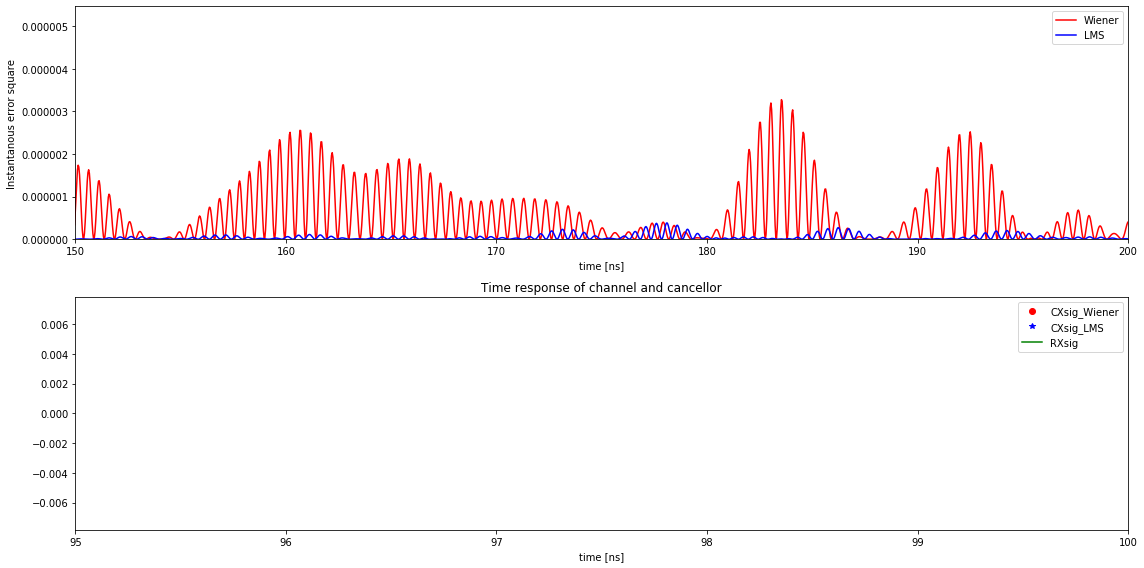

In [953]:
# Error analysis

eSquare = np.square(np.real(ESig))
eSquare_LMS = np.square(np.real(ESig_LMS))

fig = plt.figure(figsize = (16,8))

plt.subplot(211)
plt.plot(1e+9*r_[0.0:len(eSquare)]/fs, eSquare, 'r', label='Wiener')
plt.plot(1e+9*r_[0.0:len(eSquare_LMS)]/fs, eSquare_LMS, 'b', label='LMS')
plt.xlabel('time [ns]')
plt.ylabel('Instantanous error square')
plt.axis((150,200,0,max(abs(eSquare))))
plt.legend()


plt.subplot(212)
plt.plot(1e+9*r_[0.0:len(CXSig[:Ns*Ndisp])]/fs, np.real(CXSig[:Ns*Ndisp]), 'ro', label='CXsig_Wiener')
plt.plot(1e+9*r_[0.0:len(CXSig_LMS[:Ns*Ndisp])]/fs, np.real(CXSig_LMS[:Ns*Ndisp]), 'b*', label='CXsig_LMS')
plt.plot(1e+9*r_[0.0:len(RXSig[:Ns*Ndisp])]/fs, np.real(RXSig[:Ns*Ndisp]), 'g', label='RXsig')
#plt.plot(r_[0.0:len(RXSig[:Ns*Ndisp])]/fs, np.real(RXSig[:Ns*Ndisp]), 'g')

plt.xlabel('time [ns]')
plt.title('Time response of channel and cancellor')
plt.legend()
plt.axis((95,100,-max(abs(CXSig)),max(abs(CXSig))))


plt.tight_layout()




(90, 95, -0.006122207051842414, 0.006122207051842414)

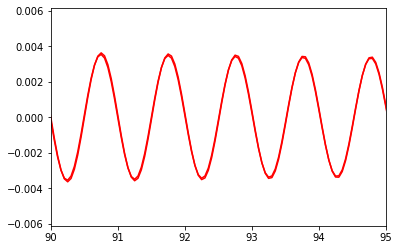

In [631]:
plt.plot(1e+9*r_[0.0:len(TXSig[:200*Ndisp])]/fs, np.real(TXSig[:200*Ndisp]), 'r', label='CXsig')
plt.plot(1e+9*r_[0.0:len(QAM_s[:200*Ndisp])]/fs, np.real(QAM_s[:200*Ndisp]), 'r', label='CXsig')
#plt.plot(1e+9*r_[0.0:len(QAM_s)]/fs, np.real(QAM_s), 'r', label='CXsig')
plt.axis((90,95,-max(abs(TXSig)),max(abs(TXSig))))

In [179]:
A=np.array([1,2,3,4])
B=np.array([3,4,5,6])
print(np.divide(A,B))

[0.33333333 0.5        0.6        0.66666667]


In [801]:
print(Array)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]
